In [30]:
import os
import torch 
import torchvision
import torch.nn as nn
from torch.nn.modules.container import Sequential
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
import datetime
import pandas as pd

In [31]:
device  = "cuda" if torch.cuda.is_available() else "cpu"

In [32]:
df = pd.read_csv(r"C:\Users\nevishwakarma\Documents\Projects\Exelon\London_Dataset\dataset\halfhourly_dataset\halfhourly_dataset\block_0.csv", parse_dates=['tstp'])

In [75]:

class EncoderNN(nn.Module):

    def __init__(self):
        super(EncoderNN, self).__init__()

        self.encoder = Sequential(                
                nn.Linear(48, 32),  
                nn.Tanh(),
                nn.Linear(32, 16),  
                nn.Tanh(), 
                nn.Linear(16, 8),  
                nn.Tanh()
        )

    def forward(self, x):
        return self.encoder(x)

In [76]:
class DecoderNN(nn.Module):

    def __init__(self):
        super(DecoderNN, self).__init__()

        self.decoder = Sequential(   
                nn.Linear(8, 16),  
                nn.Tanh(), 
                nn.Linear(16, 32),  
                nn.Tanh(), 
                nn.Linear(32, 48),  
                nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(x)

In [77]:
class AutoencoderNN(nn.Module):

  def __init__(self):
    super(AutoencoderNN,self).__init__()
    
    self.encoderNN = EncoderNN().to(device)
    self.decoderNN = DecoderNN().to(device)


  def forward(self,x):
    x = self.encoderNN(x)
    x = self.decoderNN(x)
    return x

In [78]:
model = AutoencoderNN().to(device)
print(model)

AutoencoderNN(
  (encoderNN): EncoderNN(
    (encoder): Sequential(
      (0): Linear(in_features=48, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=16, bias=True)
      (3): Tanh()
      (4): Linear(in_features=16, out_features=8, bias=True)
      (5): Tanh()
    )
  )
  (decoderNN): DecoderNN(
    (decoder): Sequential(
      (0): Linear(in_features=8, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): Tanh()
      (4): Linear(in_features=32, out_features=48, bias=True)
      (5): Tanh()
    )
  )
)


In [79]:
epochs = 30
lr = 1e-3
batch_size = 64

In [80]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [64]:
df['energy(kWh/hh)'] = df['energy(kWh/hh)'].replace('Null', 0)
df['energy(kWh/hh)'] = df['energy(kWh/hh)'].astype(float)

In [65]:
df.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000002,2012-10-12 00:30:00,0.0
1,MAC000002,2012-10-12 01:00:00,0.0
2,MAC000002,2012-10-12 01:30:00,0.0
3,MAC000002,2012-10-12 02:00:00,0.0
4,MAC000002,2012-10-12 02:30:00,0.0


In [66]:
df_train = df[(df['tstp'] > datetime.datetime(2013, 1, 1)) & (df['tstp'] < datetime.datetime(2014, 1, 1)) & (df['LCLid'] == 'MAC000002')]
df_test = df[(df['tstp'] > datetime.datetime(2014, 1, 1)) & (df['LCLid'] == 'MAC000002')]

In [67]:
training_mean = df_train["energy(kWh/hh)"].mean()
training_std = df_train["energy(kWh/hh)"].std()
df_training_value = (df_train["energy(kWh/hh)"] - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 17519


In [68]:
test_mean = df_test["energy(kWh/hh)"].mean()
test_std = df_test["energy(kWh/hh)"].std()
df_test_value = (df_test["energy(kWh/hh)"] - test_mean) / test_std
print("Number of training samples:", len(df_test_value))

Number of training samples: 2783


In [69]:
TIME_STEPS = 48

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    #for i in range(len(values) - time_steps + 1):
    for i in range(0,len(values)-time_steps+1,time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
x_test = create_sequences(df_test_value.values)
print("Training input shape: ", x_train.shape)
print("Test input shape: ", x_test.shape)

Training input shape:  (364, 48)
Test input shape:  (57, 48)


In [70]:
train_loader = DataLoader(x_train.astype(np.float32), batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [81]:
def training(model, train_loader, Epochs):
    train_loss = []
    for epoch in range(Epochs):
        running_loss = 0.0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        loss = running_loss / len(train_loader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, Epochs, loss))        

    return train_loss

In [82]:
train_loss = training(model, train_loader, 500)


Epoch 1 of 500, Train Loss: 1.015
Epoch 2 of 500, Train Loss: 0.968
Epoch 3 of 500, Train Loss: 0.951
Epoch 4 of 500, Train Loss: 0.921
Epoch 5 of 500, Train Loss: 0.883
Epoch 6 of 500, Train Loss: 0.849
Epoch 7 of 500, Train Loss: 0.813
Epoch 8 of 500, Train Loss: 0.777
Epoch 9 of 500, Train Loss: 0.754
Epoch 10 of 500, Train Loss: 0.734
Epoch 11 of 500, Train Loss: 0.711
Epoch 12 of 500, Train Loss: 0.709
Epoch 13 of 500, Train Loss: 0.699
Epoch 14 of 500, Train Loss: 0.693
Epoch 15 of 500, Train Loss: 0.680
Epoch 16 of 500, Train Loss: 0.677
Epoch 17 of 500, Train Loss: 0.671
Epoch 18 of 500, Train Loss: 0.672
Epoch 19 of 500, Train Loss: 0.657
Epoch 20 of 500, Train Loss: 0.663
Epoch 21 of 500, Train Loss: 0.662
Epoch 22 of 500, Train Loss: 0.664
Epoch 23 of 500, Train Loss: 0.659
Epoch 24 of 500, Train Loss: 0.643
Epoch 25 of 500, Train Loss: 0.647
Epoch 26 of 500, Train Loss: 0.636
Epoch 27 of 500, Train Loss: 0.644
Epoch 28 of 500, Train Loss: 0.637
Epoch 29 of 500, Train Loss: 

Text(0, 0.5, 'Loss')

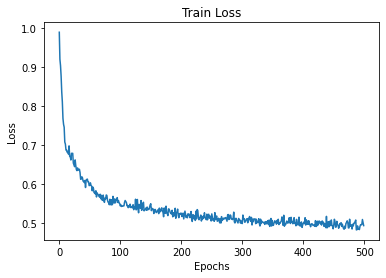

In [73]:
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [74]:
torch.save(model, r'C:\Users\nevishwakarma\Documents\Projects\Exelon\ExelonHotSockets\notebooks\ae_nn.pt')

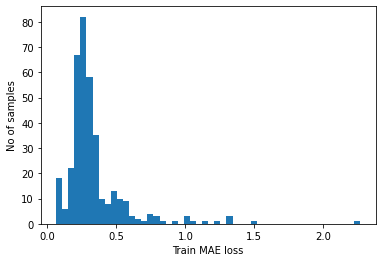

Reconstruction error threshold:  2.2695489447764925


In [49]:
x_train_t = torch.Tensor(x_train)

x_train_pred = model(x_train_t).to('cpu').detach().numpy()

train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

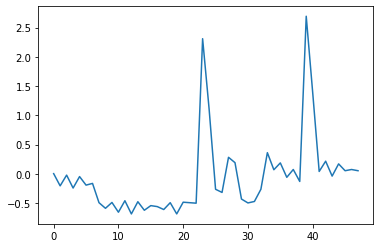

In [200]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
#plt.plot(x_train_pred[1])
plt.show()

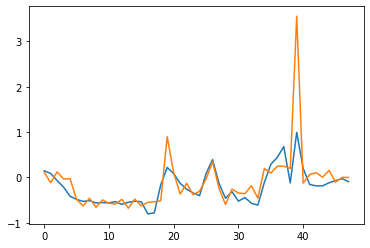

In [201]:
# Checking how the first sequence is learnt
plt.plot(x_train_pred[5])
plt.plot(x_train[5])
plt.show()

In [202]:
x_test_t = torch.Tensor(x_test)

x_test_pred = model(x_test_t).to('cpu').detach().numpy()



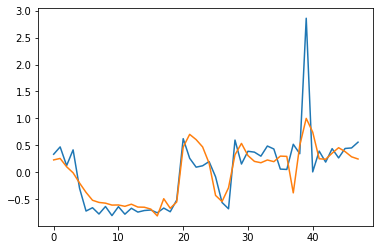

In [203]:
plt.plot(x_test[0])
plt.plot(x_test_pred[0])
plt.show()